In [ ]:
%cd ../..

In [2]:
from src.core.utils import create_directory

path_to_save = "results/analysis"

create_directory(path_to_save)

True

# Results Table

In [3]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, root_mean_squared_error
import ast
import numpy as np


def evaluate_essay_predictions(root_path: str, test_path: str, metric: str = "qwk") -> pd.DataFrame:
    """
    Evaluate LLM essay predictions using QWK or RMSE.

    Parameters:
    - root_path (str): Path to the directory containing LLM results.
    - test_path (str): Path to the CSV file containing the test data.
    - metric (str): Metric to compute, either 'qwk' or 'rmse'.

    Returns:
    - pd.DataFrame: DataFrame with evaluation results.
    """

    # Convert string path to a Path object for easy directory traversal
    root = Path(root_path)
    final_metrics = []  # List to accumulate results for all settings/models/prompts

    # Load the test dataset, keeping only the 'title' and 'essay' columns
    df_test = pd.read_csv(test_path)[["title", "essay"]]

    # Convert string representations of lists in 'essay' column back to Python lists
    df_test["essay"] = df_test["essay"].apply(ast.literal_eval)

    # Join essay paragraphs with double newline to reconstruct the full essay text
    df_test["essay"] = df_test["essay"].apply(lambda x: "\n\n".join(x))

    # Iterate through each subdirectory in root_path, assumed to be different 'settings'
    for setting_dir in root.iterdir():
        if setting_dir.is_dir():
            setting = setting_dir.name

            # Within each setting, iterate through model directories
            for model_dir in setting_dir.iterdir():
                if model_dir.is_dir():
                    model = model_dir.name

                    # Within each model directory, iterate through prompt directories
                    for prompt_dir in model_dir.iterdir():
                        if prompt_dir.is_dir():
                            prompt = prompt_dir.name

                            # Compose the path to the results CSV for this prompt
                            csv_path = prompt_dir / "essay_results.csv"

                            # Proceed only if the results CSV exists
                            if csv_path.exists():
                                # Load the prediction results
                                df = pd.read_csv(csv_path)

                                # Merge test data with predictions on 'title' and 'essay' columns
                                df_merged = pd.merge(df_test, df, on=["title", "essay"], how="inner")

                                # Check if all test samples are covered in the results
                                if len(df_merged) != len(df_test):
                                    print(f"[WARNING] {csv_path} does not cover all test data. Skipping.")
                                    continue  # Skip incomplete results

                                # Identify columns with ground truth labels (ending with '_real')
                                real_cols = [col for col in df_merged.columns if col.endswith("_real")]

                                # Prepare a dictionary to store evaluation metrics for current setting/model/prompt
                                result = {
                                    "setting": setting,
                                    "model": model,
                                    "prompt": prompt
                                }

                                # Calculate the selected metric (QWK or RMSE) for each label
                                count = 1
                                for real_col in real_cols:
                                    # Corresponding prediction column by removing '_real' suffix
                                    pred_col = real_col.replace("_real", "")
                                    if pred_col in df_merged.columns:
                                        # Extract true and predicted values, fill missing with zero
                                        y_true = df_merged[real_col].fillna(0)
                                        y_pred = df_merged[pred_col].fillna(0)

                                        # Compute metric based on user's choice
                                        if metric == "qwk":
                                            value = cohen_kappa_score(y_true, y_pred, weights="quadratic")
                                        elif metric == "rmse":
                                            value = root_mean_squared_error(y_true, y_pred)
                                        else:
                                            raise ValueError("Metric must be either 'qwk' or 'rmse'.")

                                        # Store the computed metric with a descriptive key
                                        result[f"C{count}"] = value
                                        count += 1

                                # Calculate metric for the total score by summing all labels
                                sum_real = df_merged[real_cols].fillna(0).sum(axis=1)
                                pred_cols = [col.replace("_real", "") for col in real_cols]
                                sum_pred = df_merged[pred_cols].fillna(0).sum(axis=1)

                                # Compute overall metric on summed scores
                                if metric == "qwk":
                                    total_score = cohen_kappa_score(sum_real, sum_pred, weights="quadratic")
                                else:
                                    total_score = root_mean_squared_error(sum_real, sum_pred)

                                # Add the total metric score to the results dictionary
                                result[f"total"] = total_score

                                # Append current results to the list
                                final_metrics.append(result)

    # Convert all results to a DataFrame and return
    df = pd.DataFrame(final_metrics)
    df.columns = [col.capitalize() for col in df.columns]
    df = df.drop("Prompt", axis=1)  # Drop 'prompt' column as it is not needed

    return df


In [4]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, root_mean_squared_error
import ast
import numpy as np


def evaluate_essay_predictions(root_path: str, test_path: str, metric: str = "qwk") -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluate LLM essay predictions using QWK or RMSE.

    Parameters:
    - root_path (str): Path to the directory containing LLM results.
    - test_path (str): Path to the CSV file containing the test data.
    - metric (str): Metric to compute, either 'qwk' or 'rmse'.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: (df_mean, df_std) with evaluation results.
    """

    # Convert string path to a Path object for easy directory traversal
    root = Path(root_path)
    final_metrics = []  # List to accumulate results for all settings/models/prompts

    # Load the test dataset, keeping only the 'title' and 'essay' columns
    df_test = pd.read_csv(test_path)[["title", "essay"]]

    # Convert string representations of lists in 'essay' column back to Python lists
    df_test["essay"] = df_test["essay"].apply(ast.literal_eval)

    # Join essay paragraphs with double newline to reconstruct the full essay text
    df_test["essay"] = df_test["essay"].apply(lambda x: "\n\n".join(x))

    # Iterate through each subdirectory in root_path, assumed to be different 'settings'
    for setting_dir in root.iterdir():
        if setting_dir.is_dir():
            setting = setting_dir.name

            # Within each setting, iterate through model directories
            for model_dir in setting_dir.iterdir():
                if model_dir.is_dir():
                    model = model_dir.name

                    # Within each model directory, iterate through prompt directories
                    for prompt_dir in model_dir.iterdir():
                        if prompt_dir.is_dir():
                            prompt = prompt_dir.name

                            # Compose the path to the results CSV for this prompt
                            csv_path = prompt_dir / "essay_results.csv"

                            # Proceed only if the results CSV exists
                            if csv_path.exists():
                                # Load the prediction results
                                df = pd.read_csv(csv_path)

                                # Merge test data with predictions on 'title' and 'essay' columns
                                df_merged = pd.merge(df_test, df, on=["title", "essay"], how="inner")

                                # Check if all test samples are covered in the results
                                if len(df_merged) != len(df_test):
                                    print(f"[WARNING] {csv_path} does not cover all test data. Skipping.")
                                    continue  # Skip incomplete results

                                # Identify columns with ground truth labels (ending with '_real')
                                real_cols = [col for col in df_merged.columns if col.endswith("_real")]

                                # Prepare a dictionary to store evaluation metrics for current setting/model/prompt
                                result = {
                                    "setting": setting,
                                    "model": model,
                                    "prompt": prompt
                                }

                                # Calculate the selected metric (QWK or RMSE) for each label
                                count = 1
                                for real_col in real_cols:
                                    # Corresponding prediction column by removing '_real' suffix
                                    pred_col = real_col.replace("_real", "")
                                    if pred_col in df_merged.columns:
                                        # Extract true and predicted values, fill missing with zero
                                        y_true = df_merged[real_col].fillna(0)
                                        y_pred = df_merged[pred_col].fillna(0)

                                        # Compute metric based on user's choice
                                        if metric == "qwk":
                                            value = cohen_kappa_score(y_true, y_pred, weights="quadratic")
                                        elif metric == "rmse":
                                            value = root_mean_squared_error(y_true, y_pred)
                                        else:
                                            raise ValueError("Metric must be either 'qwk' or 'rmse'.")

                                        # Store the computed metric with a descriptive key
                                        result[f"C{count}"] = value
                                        count += 1

                                # Calculate metric for the total score by summing all labels
                                sum_real = df_merged[real_cols].fillna(0).sum(axis=1)
                                pred_cols = [col.replace("_real", "") for col in real_cols]
                                sum_pred = df_merged[pred_cols].fillna(0).sum(axis=1)

                                # Compute overall metric on summed scores
                                if metric == "qwk":
                                    total_score = cohen_kappa_score(sum_real, sum_pred, weights="quadratic")
                                else:
                                    total_score = root_mean_squared_error(sum_real, sum_pred)

                                # Add the total metric score to the results dictionary
                                result[f"total"] = total_score

                                # Append current results to the list
                                final_metrics.append(result)

    # Convert all results to a DataFrame
    df = pd.DataFrame(final_metrics)
    df.columns = [col.capitalize() for col in df.columns]
    df = df.drop("Prompt", axis=1)

    df_mean = df.groupby(["Setting", "Model"]).mean(numeric_only=True).reset_index()
    df_std = df.groupby(["Setting"]).std(numeric_only=True).reset_index()

    return df_mean, df_std


In [5]:
import pandas as pd

def prepare_df(df_metric: pd.DataFrame, metric_name: str, base_path: str, file_name: str) -> pd.DataFrame:
    """
    Prepares a DataFrame for plotting by renaming settings, 
    ordering categorical columns, sorting, and saving to CSV.

    Parameters:
    - df_metric: DataFrame containing 'Setting', 'Model', and metric columns
    - metric_name: Name of the metric ('QWK' or 'RMSE')
    - base_path: Base directory path where the CSV will be saved
    - file_name: Name of the file to save (without extension)

    Returns:
    - The sorted and processed DataFrame
    """
    # Rename and order settings
    setting_rename = {
        "zero_shot": "Zero-shot",
        "few_shot": "One-shot",
        "writer": "Self-generated reference"
    }
    setting_order = ["Zero-shot", "One-shot", "Self-generated reference"]
    model_order = [
        "Qwen3-8B",
        "DeepSeek-R1-0528-Qwen3-8B",
        "Mistral-Small-3.1-24B-Instruct-2503",
        "llama-3.1-nemotron-ultra-253b-v1",
        "DeepSeek-R1T-Chimera"
    ]

    # Apply renaming and ordering
    df_metric["Setting"] = df_metric["Setting"].replace(setting_rename)
    df_metric["Setting"] = pd.Categorical(df_metric["Setting"], categories=setting_order, ordered=True)
    if 'Model' in df_metric.columns:
        df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)

    # Sort and save
    if 'Model' in df_metric.columns:
        df_sorted = df_metric.sort_values(by=["Setting", "Model"]).reset_index(drop=True)
    else:
        df_sorted = df_metric.sort_values(by=["Setting"]).reset_index(drop=True)
    df_sorted.to_csv(f"{base_path}/{file_name}.csv", index=False)

    return df_sorted


In [6]:
df_mean_qwk, df_std_qwk = evaluate_essay_predictions("results/essay", "dataset/testing.csv", metric="qwk")
df_mean_qwk = prepare_df(df_mean_qwk, "QWK", path_to_save, "results_mean_QWK")
df_std_qwk = prepare_df(df_std_qwk, "QWK", path_to_save, "results_std_QWK")

In [7]:
df_mean_qwk

,Setting,Model,C1,C2,C3,C4,C5,Total
0,Zero-shot,Qwen3-8B,0.252611,0.209907,0.301489,0.204653,0.190850,0.286687
1,Zero-shot,DeepSeek-R1-0528-Qwen3-8B,0.168684,0.239425,0.342355,0.251787,0.220871,0.316103
2,Zero-shot,Mistral-Small-3.1-24B-Instruct-2503,0.297758,0.422291,0.426677,0.222002,0.315914,0.476212
3,Zero-shot,llama-3.1-nemotron-ultra-253b-v1,0.404948,0.381846,0.367129,0.236896,0.278432,0.453403
4,Zero-shot,DeepSeek-R1T-Chimera,0.373133,0.431981,0.458703,0.320573,0.360798,0.497451
5,One-shot,Qwen3-8B,0.402393,0.406202,0.404847,0.380425,0.328095,0.509321
6,One-shot,DeepSeek-R1-0528-Qwen3-8B,0.293679,0.368785,0.380072,0.371058,0.315820,0.462950
7,One-shot,Mistral-Small-3.1-24B-Instruct-2503,0.354075,0.484719,0.531402,0.313245,0.336614,0.529330
8,One-shot,llama-3.1-nemotron-ultra-253b-v1,0.427368,0.500971,0.495741,0.347967,0.348444,0.568857
9,One-shot,DeepSeek-R1T-Chimera,0.383408,0.535326,0.524606,0.375931,0.400550,0.560579


In [8]:
df_std_qwk

,Setting,C1,C2,C3,C4,C5,Total
0,Zero-shot,0.094678,0.104858,0.063476,0.044598,0.069002,0.097285
1,One-shot,0.051417,0.069237,0.070198,0.027831,0.032792,0.042711
2,Self-generated reference,0.062647,0.069257,0.080317,0.049865,0.051260,0.082598


In [9]:
df_mean_rmse, df_std_rmse = evaluate_essay_predictions("results/essay", "dataset/testing.csv", metric="rmse")
df_mean_rmse = prepare_df(df_mean_rmse, "RMSE", path_to_save, "results_mean_RMSE")
df_std_rmse = prepare_df(df_std_rmse, "RMSE", path_to_save, "results_std_RMSE")

In [10]:
df_mean_rmse

,Setting,Model,C1,C2,C3,C4,C5,Total
0,Zero-shot,Qwen3-8B,41.064551,41.880017,36.969769,48.631416,57.387233,186.538204
1,Zero-shot,DeepSeek-R1-0528-Qwen3-8B,50.351534,47.711475,40.979267,54.059680,67.318485,208.646897
2,Zero-shot,Mistral-Small-3.1-24B-Instruct-2503,45.278535,37.346381,35.125763,52.193853,61.335953,165.354994
3,Zero-shot,llama-3.1-nemotron-ultra-253b-v1,33.806170,38.544964,35.620284,57.040725,60.532140,165.805745
4,Zero-shot,DeepSeek-R1T-Chimera,35.258314,36.269159,34.183521,46.322485,55.212286,159.978133
5,One-shot,Qwen3-8B,35.423304,39.678004,36.172570,40.319424,49.675331,151.347687
6,One-shot,DeepSeek-R1-0528-Qwen3-8B,41.852162,43.114871,40.693693,47.613605,60.647622,177.924543
7,One-shot,Mistral-Small-3.1-24B-Instruct-2503,42.102194,36.397546,33.249652,51.880104,61.639410,167.080923
8,One-shot,llama-3.1-nemotron-ultra-253b-v1,34.556752,38.605427,35.456210,54.188958,58.832172,160.254899
9,One-shot,DeepSeek-R1T-Chimera,36.525481,34.012517,33.214560,46.598590,54.446593,157.406088


In [11]:
df_std_rmse

,Setting,C1,C2,C3,C4,C5,Total
0,Zero-shot,6.898625,4.622375,2.659151,4.26194,4.602687,20.265823
1,One-shot,3.615742,3.433584,3.057160,5.34768,4.958457,10.171103
2,Self-generated reference,3.416366,3.634660,3.357683,4.21631,4.103723,13.808999


# Plots

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_barplot(df_metric, metric_name: str, path_to_save: str):
    """
    Plots a bar chart for the given metric (QWK or RMSE).

    Parameters:
    - df_metric: DataFrame containing the columns ['Setting', 'C1', 'C2', 'C3', 'C4', 'C5', 'Total']
    - metric_name: Name of the metric to display and use in the filename ('QWK' or 'RMSE')
    - path_to_save: Directory path where the PDF will be saved
    """
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5', 'Total']
    
    df_plot = df_metric[['Setting'] + competencies].copy()
    df_melted = df_plot.melt(
        id_vars='Setting',
        value_vars=competencies,
        var_name='Competence',
        value_name='Score'
    )
    
    palette = sns.color_palette('Set2')
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_melted,
        x='Competence',
        y='Score',
        hue='Setting',
        palette=palette,
        estimator='mean',
        ci=None
    )
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

    plt.xlabel('Competency')
    plt.ylabel(f'Mean {metric_name.upper()}')
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.savefig(f"{path_to_save}/{metric_name.upper()}-mean-setting.pdf")
    plt.show()


/tmp/ipykernel_14059/2913314188.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_14059/2913314188.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(


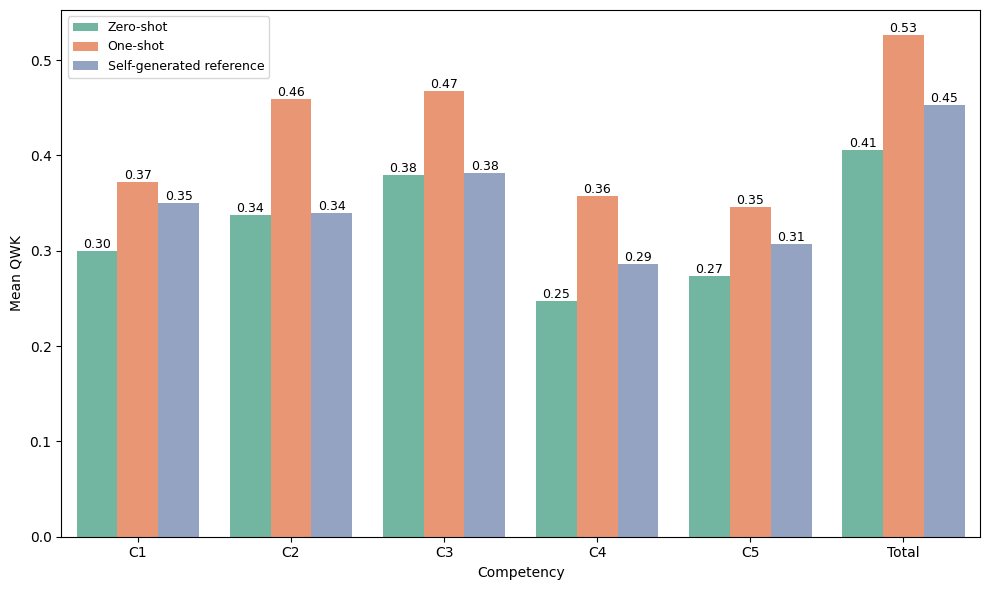

In [13]:
plot_metric_barplot(df_mean_qwk, 'QWK', path_to_save)

/tmp/ipykernel_14059/2913314188.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_14059/2913314188.py:26: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(


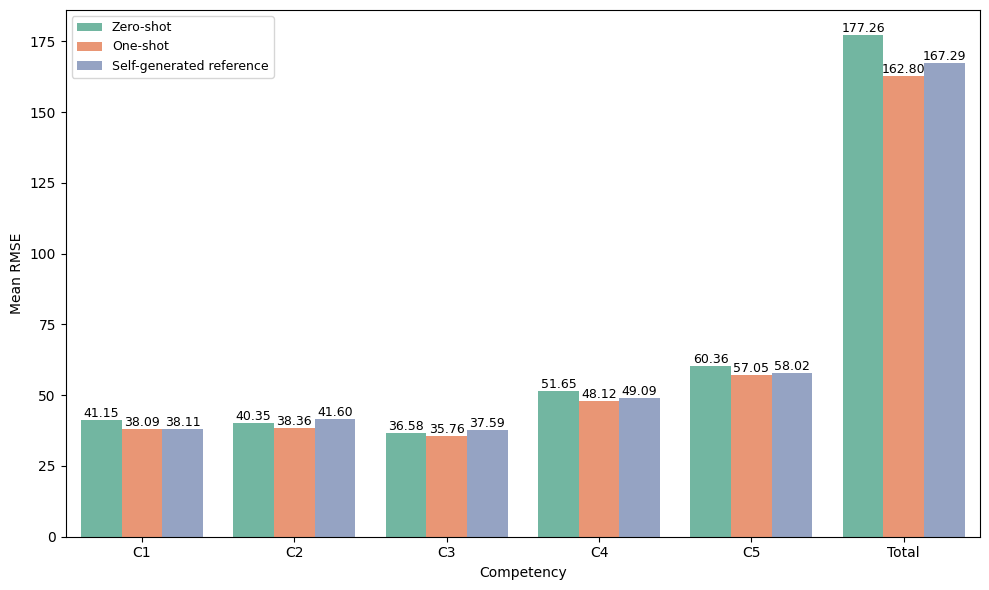

In [14]:
plot_metric_barplot(df_mean_rmse, 'RMSE', path_to_save)